In [ ]:
!pip install ultralytics -q

In [43]:
import requests
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import torch
import shutil
from PIL import Image
from dataclasses import dataclass
from typing import Iterable
import yaml

from ultralytics import YOLO
from pprint import pprint
from torchmetrics.detection.mean_ap import MeanAveragePrecision

### Download dataset

In [ ]:
# !wget -nc "https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1" -O Dataset.zip
# !unzip -q Dataset.zip

In [64]:
@dataclass
class TrainingConfig:
    DATA_DIR = "Dataset/"
    TRAIN_LABELS_PATH = "Dataset/train/labels/"
    TRAIN_PATH = "Dataset/train/images/"
    VAL_LABELS_PATH = "Dataset/val/labels"
    VAL_PATH = "Dataset/val/images"
    
training_config = TrainingConfig()

### YOLO Annotation Format

In [65]:
base_dir = training_config.DATA_DIR
train_src = os.path.join(base_dir, "train", "Vehicle registration plate")
val_src = os.path.join(base_dir, "validation", "Vehicle registration plate")

train_image_dest = os.path.join(base_dir, "train", "images")
train_labels_dest = os.path.join(base_dir, "train", "labels")

val_images_dest = os.path.join(base_dir, "valid", "images")
val_labels_dest = os.path.join(base_dir, "valid", "labels")


os.makedirs(train_image_dest, exist_ok=True)
os.makedirs(train_labels_dest, exist_ok=True)
os.makedirs(val_images_dest, exist_ok=True)
os.makedirs(val_labels_dest, exist_ok=True)


In [ ]:
def convert_annotations(src_folder, images_dest, labels_dest):
    for filename in os.listdir(src_folder):
        if filename.lower().endswith(('.jpg', ".jpeg", ".png")):
            shutil.move(os.path.join(src_folder, filename), os.path.join(images_dest, filename))
            
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_src_path = os.path.join(src_folder, "Label", label_filename)
            
            if os.path.exists(label_src_path):
                with open(label_src_path, 'r') as f:
                    lines = f.readlines()
                    
            
            yolo_labels = []
            for line in lines:
                print(line)
                parts = line.strip().split() #remove any leading and trailing spaces and splits by space
                print("Parts", parts)
                if len(parts) >= 0:
                    class_id = 0
                    x_min = float(parts[3])
                    y_min = float(parts[4])
                    x_max = float(parts[5])
                    y_max = float(parts[6])
                  
                    
                    img_path = os.path.join(images_dest, filename)
                    
                    with Image.open(img_path) as img_tmp:
                        img_width, img_height = img_tmp.size
                    
                    x_center = (x_min + x_max) / 2
                    y_center = (y_min + y_max) / 2
                    
                    width = x_max - x_min
                    height = y_max - y_min
                    
                    #Normalize coord for YOLO
                    x_center_norm = x_center / img_width
                    y_center_norm = y_center / img_height
                    width_norm = width / img_width
                    height_norm = height / img_height
                    
                    yolo_labels.append(f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}\n")
                    
            with open(os.path.join(labels_dest, label_filename), "w") as f:
                f.writelines(yolo_labels) 
                    
 #Train                       
convert_annotations(train_src, train_image_dest, train_labels_dest)

#Val
convert_annotations(val_src, val_images_dest, val_labels_dest)    
                    

In [ ]:
# For Annotation# !wget -nc "https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1" -O Dataset.zip
# !unzip -q Dataset.zip
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [48]:
classes = [
    'License Plate' #idx : 0
]

colors = [(238, 130, 238)]

In [49]:
def plot_box(image, bboxes, labels):
    
    h, w = image.shape[:2]
    for box_idx, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        #denormalize
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        
        thickness = max(2, int(w/275)) #adjust accord to img size
        
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color = colors[int(labels[box_idx])][::-1], #rev order from BGR to RGB
            thickness=thickness
        )
        
        
        cv2.putText(
            image,
            text = classes[int(labels[box_idx])],
            org = (xmin, ymin - 5),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 0.75,
            
            color = colors[int(labels[box_idx])][::-1],
            thickness = thickness
        )
        
        
    return image

In [50]:
def plot(image_paths, labels_path, num_samples):
    
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'*.JPG'))
    
    all_images.sort()
    
    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)
    
        image_name = all_images[j]
        print("Before", image_name)

        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])  #get the file name alone removing parent dirs
        print("After", image_name)
        
        image = cv2.imread(all_images[j])
        with open(os.path.join(labels_path, image_name + '.txt'), 'r') as f:
            bboxes = []
            labels = []
            
            lines = f.readlines()
            for line in lines:
                
                class_label = line[0]  # class label
                bbox_string = line[2:] # get the bbox
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                
                bboxes.append([x_c, y_c, w, h])
                labels.append(class_label)
                
                result_image = plot_box(image, bboxes, labels)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()
                
                
                

Before Dataset/train/images/84b362322b43c594.jpg
After 84b362322b43c594
Before Dataset/train/images/63f9d2ff812794a7.jpg
After 63f9d2ff812794a7
Before Dataset/train/images/0b3af9c7022196a7.jpg
After 0b3af9c7022196a7
Before Dataset/train/images/c0ca4b462ef35a67.jpg
After c0ca4b462ef35a67


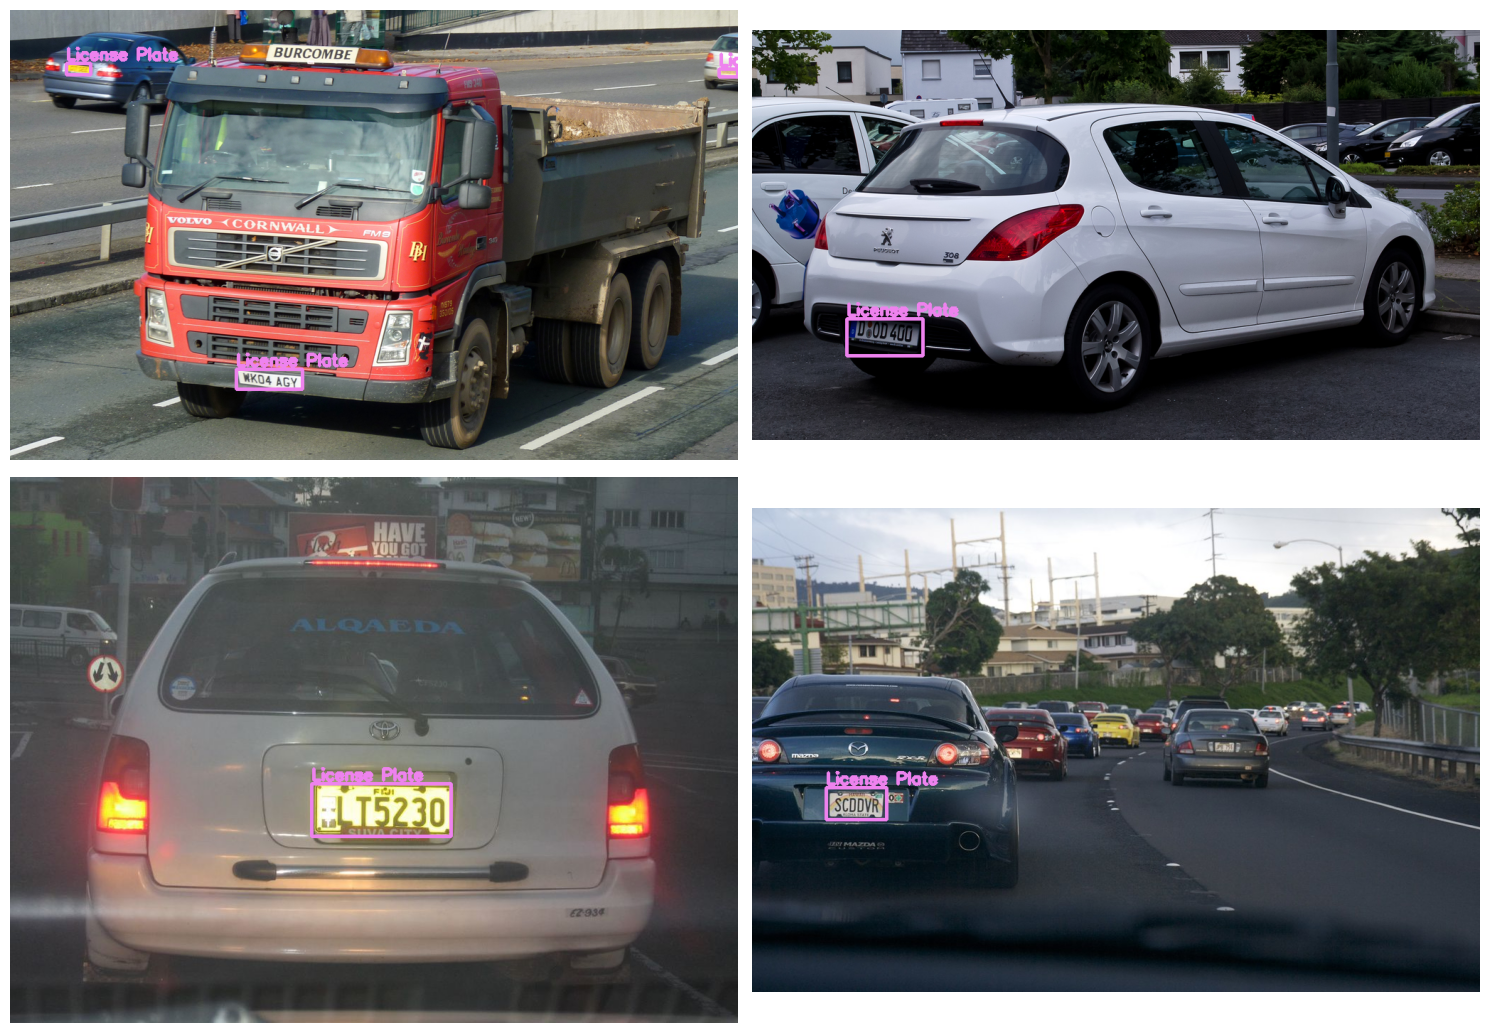

In [53]:
plot(
    image_paths = training_config.TRAIN_PATH,
    labels_path = training_config.TRAIN_LABELS_PATH,
    num_samples = 4
)

#### Create data.yaml for training

In [52]:
cwd = os.getcwd()
print(cwd)

/home/jaykumaran/Vision_Projects/ANPR-OCR


In [55]:
attr = {
    'path': cwd + '/Dataset',
    'train': 'train/images',
    'val': 'valid/images',
    
    'names': {
        0 : 'License Plate'
    }
}

with open('license_plate_data.yaml', 'w') as f:
    yaml.dump(attr, f)
    

### YOLOv11 training

**Note:** Ultralytics, from YOLOv5 to YOLO11, is licensed under AGPL3.0 license. If used, it requires a payment of approximately $5,000 USD per year (this is speculated price for enterprice, not sure though need a clarification on this further)

For alternative object detection models, you can consider RetinaNet, MobileNetV3, or SSD.
 
YOLO11 Docs: https://docs.ultralytics.com/models/yolo11/#key-features 

In [57]:
from ultralytics import YOLO

model = YOLO('yolo11m.pt')

100%|██████████| 38.8M/38.8M [00:03<00:00, 10.2MB/s]


In [59]:
model.train(
    data = "license_plate_data.yaml",
    epochs = 30,
    batch = 8,
    imgsz = 640, # default
    name = "yolo11m-license", # project name
    exist_ok = True # check for project name
)

Ultralytics 8.3.73 🚀 Python-3.10.15 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5898MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=license_plate_data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11m-license, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 9.62MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              


  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 11.5MB/s]


AMP: checks passed ✅


train: Scanning /home/jaykumaran/Vision_Projects/ANPR-OCR/Dataset/train/labels... 5307 images, 1 backgrounds, 0 corrupt: 100%|██████████| 5308/5308 [00:08<00:00, 632.18it/s]


train: New cache created: /home/jaykumaran/Vision_Projects/ANPR-OCR/Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /home/jaykumaran/Vision_Projects/ANPR-OCR/Dataset/valid/labels... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:00<00:00, 619.09it/s]

val: New cache created: /home/jaykumaran/Vision_Projects/ANPR-OCR/Dataset/valid/labels.cache


Plotting labels to runs/detect/yolo11m-license/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11m-license
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.68G       1.75      1.623      1.358         12        640: 100%|██████████| 664/664 [03:12<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.79it/s]


                   all        386        512      0.593      0.444      0.486      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.61G      1.817      1.477      1.411          7        640: 100%|██████████| 664/664 [03:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.09it/s]

                   all        386        512      0.717      0.648      0.686      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.64G      1.744      1.399      1.379          8        640: 100%|██████████| 664/664 [03:08<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.09it/s]

                   all        386        512      0.652      0.662      0.644      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.65G      1.666      1.287      1.321          8        640: 100%|██████████| 664/664 [03:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.16it/s]

                   all        386        512      0.853       0.75      0.803      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.65G      1.649      1.226      1.307         14        640: 100%|██████████| 664/664 [03:10<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]

                   all        386        512      0.784      0.732      0.783      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.64G      1.586      1.126      1.271          8        640: 100%|██████████| 664/664 [03:11<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.55it/s]

                   all        386        512      0.861      0.746      0.811      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.65G      1.566      1.068      1.269          3        640: 100%|██████████| 664/664 [03:10<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]

                   all        386        512      0.915      0.758      0.833      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.63G      1.532       1.04      1.234          8        640: 100%|██████████| 664/664 [03:11<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]

                   all        386        512      0.916      0.771      0.863      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.65G      1.528      1.027      1.232         10        640: 100%|██████████| 664/664 [03:10<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.76it/s]

                   all        386        512       0.91      0.742      0.838       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.65G      1.489     0.9848       1.22         13        640: 100%|██████████| 664/664 [03:11<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.07it/s]

                   all        386        512      0.911      0.796      0.871      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.65G      1.483     0.9581      1.211          6        640: 100%|██████████| 664/664 [03:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.83it/s]

                   all        386        512       0.88        0.8      0.852      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.65G      1.472     0.9354      1.211          9        640: 100%|██████████| 664/664 [03:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.82it/s]

                   all        386        512      0.907      0.833      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.65G      1.451     0.8983      1.195          6        640: 100%|██████████| 664/664 [03:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.17it/s]

                   all        386        512      0.898      0.839      0.878      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.64G      1.433     0.9024      1.183          4        640: 100%|██████████| 664/664 [03:08<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.82it/s]

                   all        386        512      0.902       0.83      0.874      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.64G      1.412     0.8858      1.181          4        640: 100%|██████████| 664/664 [03:08<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.94it/s]

                   all        386        512      0.897      0.828      0.888      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.65G      1.423     0.8649      1.194         12        640: 100%|██████████| 664/664 [03:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.16it/s]

                   all        386        512      0.916      0.848      0.896      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.65G      1.405     0.8577      1.165         13        640: 100%|██████████| 664/664 [03:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.74it/s]

                   all        386        512      0.934       0.82      0.898      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.65G      1.382     0.8339      1.158         11        640: 100%|██████████| 664/664 [03:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.03it/s]

                   all        386        512      0.927      0.854      0.902      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.65G      1.378     0.8145       1.16          9        640: 100%|██████████| 664/664 [03:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.12it/s]

                   all        386        512      0.915      0.857      0.909      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.65G      1.359     0.8055      1.153         14        640: 100%|██████████| 664/664 [03:06<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.08it/s]

                   all        386        512      0.952      0.846      0.907      0.655


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.64G      1.388     0.7866      1.164          5        640: 100%|██████████| 664/664 [03:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.01it/s]

                   all        386        512      0.919       0.87      0.907      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.64G      1.384     0.7565      1.173          3        640: 100%|██████████| 664/664 [03:08<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.89it/s]

                   all        386        512      0.943      0.844      0.921       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.64G      1.362     0.7507      1.149          6        640: 100%|██████████| 664/664 [03:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.55it/s]

                   all        386        512      0.941      0.861      0.914      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.64G      1.355     0.7262      1.154          7        640: 100%|██████████| 664/664 [03:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]

                   all        386        512      0.928      0.885      0.915      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.65G      1.345     0.7194      1.152          9        640: 100%|██████████| 664/664 [03:17<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]

                   all        386        512      0.932      0.875      0.918      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.64G      1.329     0.7053      1.141          4        640: 100%|██████████| 664/664 [03:17<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.42it/s]

                   all        386        512      0.935      0.863       0.91      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.65G       1.32     0.6861      1.138          4        640: 100%|██████████| 664/664 [03:11<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.58it/s]

                   all        386        512      0.928      0.878      0.918      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.63G        1.3      0.679      1.126          4        640: 100%|██████████| 664/664 [03:10<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]

                   all        386        512      0.934      0.875      0.915      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.65G      1.289     0.6606      1.124          8        640: 100%|██████████| 664/664 [03:10<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.53it/s]

                   all        386        512      0.936      0.886       0.92      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.65G      1.271     0.6558      1.118          5        640: 100%|██████████| 664/664 [03:09<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]

                   all        386        512      0.942      0.891      0.922      0.694



30 epochs completed in 1.630 hours.
Optimizer stripped from runs/detect/yolo11m-license/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/yolo11m-license/weights/best.pt, 40.5MB

Validating runs/detect/yolo11m-license/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.10.15 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5898MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


                   all        386        512      0.942      0.892      0.922      0.694
Speed: 0.3ms preprocess, 8.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo11m-license


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f6acccabc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model_path = "runs/detect/yolo11m-license/weights/best.pt"
model = YOLO(trained_model_path)

In [61]:
def plot_box_predictions(image, bboxes, labels, scores):
    h, w = image.shape[:2]
    for box_idx, box in enumerate(bboxes):
        
        # Extract coords
        
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        
        thickness = max(2, int(w / 275))
        
        cv2.rectangle(
            image,
            (x_min, y_min), (x_max, y_max),
            color = colors[int(labels[box_idx])][::-1], #rev order from BGR to RGB
            thickness=thickness
        )
        
        
        score_text = f"{scores[box_idx]:.2f}"
        
        cv2.putText(
            image,
            text = score_text,
            org = (x_min, y_min - 10),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 0.75,
            
            color = colors[int(labels[box_idx])][::-1], # rev the color from BGR to RGB
            thickness = thickness,
            lineType = cv2.LINE_AA # anti alias
        )
        
        
    return image  

In [62]:
@torch.inference_mode(mode = True)
def run_inference(device, model, image_path, label_path, random_selection = False, num_samples = 1):
    model.to(device)
    
    #Evaluation
    map_evaluator = MeanAveragePrecision(class_metrics = True).to(device)
    
    batch_size = 4
    
    images = [os.path.join(image_path, img) for img in os.listdir(image_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    if random_selection:
        
        num_samples = min(num_samples, len(images))
        images = random.sample(images, num_samples) # sample 
        
        
    
    for i in range(0, len(images), batch_size):
        
        
        batch = images[i: i + batch_size]
        #inference as batch
        results = model(batch, conf = 0.25)
        
        predictions = []
        targets = []
        
        for j, result in enumerate(results):
            image = batch[j]
            
            # Extract preds directly as tensors 
            pred_boxes = result.boxes.xyxy.to(device)
            pred_scores = result.boxes.conf.to(device)
            pred_labels = result.boxes.cls.int().to(device)
            
            if random_selection:
                image = cv2.imread(image)
                result_image = plot_box_predictions(image, pred_boxes, pred_labels, pred_scores)
                print(f"Boxes: {pred_boxes}, Labels: {pred_labels}")
                
                plt.subplot(2, 2, i+1)
                plt.imshow(result_image[:, :, ::-1])
                plt.axis('off')
                plt.subplots_adjust(wspace = 1)
                plt.tight_layout()
                plt.show()

            predictions.append({
                "boxes": pred_boxes,
                "scores": pred_scores,
                "labels": pred_labels
            })
            
            
            # Extract Ground Truth
            image_name = os.path.splitext(os.path.basename(batch[j]))[0]
            label_file = os.path.join(label_path, image_name + ".txt")
            
            gt_boxes, gt_labels = [], []
            
            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        
                        parts  = line.strip().split()
                        class_id = int(parts[0])
                        
                        x_center, y_center, width, height = map(float, parts[1:])
                        
            
                        # Denormalize
                        with Image.open(batch[j]) as img:
                            img_width, img_height = img.size
                        
                        x_min = (x_center - width / 2)  * img_width
                        y_min = (y_center - height / 2) * img_height
                        x_max = (x_center + width / 2)  * img_width
                        y_max = (y_center + height / 2) * img_height
                        
                        gt_boxes.append([x_min, y_min, x_max, y_max])
                        gt_labels.append(class_id)
                        
                targets.append({
                    "boxes": torch.tensor(gt_boxes, dtype = torch.float32).to(device),
                    "labels": torch.tensor(gt_labels, dtype = torch.int64).to(device)
                })
                
                
            else:
                
                # When no GT is available
                targets.append({
                    "boxes": torch.zeroes((0, 4), dtype = torch.float32).to(device),
                    "labels": torch.zeroes((0, 1), dtype = torch.int64).to(device)
                })
        
        map_evaluator.update(predictions, targets)
        
        metrics = map_evaluator.compute()
        
        return metrics
             


0: 640x640 1 License Plate, 20.0ms
1: 640x640 1 License Plate, 20.0ms
2: 640x640 2 License Plates, 20.0ms
Speed: 2.2ms preprocess, 20.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Boxes: tensor([[426.4651, 622.1178, 571.3641, 698.2202]], device='cuda:0'), Labels: tensor([0], device='cuda:0', dtype=torch.int32)


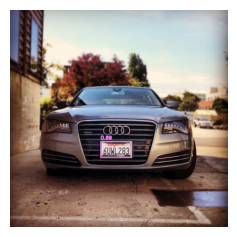

Boxes: tensor([[509.2887, 520.6874, 672.6152, 564.0917]], device='cuda:0'), Labels: tensor([0], device='cuda:0', dtype=torch.int32)


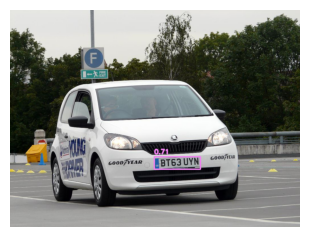

Boxes: tensor([[127.1936, 744.2083, 275.9866, 839.0109],
        [206.7187, 441.1738, 249.1232, 457.5672]], device='cuda:0'), Labels: tensor([0, 0], device='cuda:0', dtype=torch.int32)


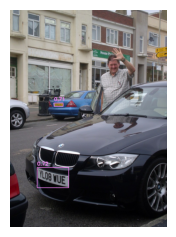

In [66]:
val_metrics = run_inference(device, model, val_images_dest, val_labels_dest, random_selection = True, num_samples = 3)

#### Eval metrics

In [67]:
val_map = val_metrics['map']
val_map_50 = val_metrics['map_50']
val_map_75 = val_metrics['map_75']

val_ap_small = val_metrics['map_small']
val_ap_medium = val_metrics['map_medium']
val_ap_large = val_metrics['map_large']

val_ar = val_metrics['mar_1']
val_ar_10 = val_metrics['mar_10']
val_ar_100 = val_metrics['mar_100']

val_ar_small = val_metrics['mar_small']
val_ar_medium = val_metrics['mar_medium']
val_ar_large = val_metrics['mar_large']



# Prepare a report showing COCO metrics

report = f"""
Average Precision (AP) @[ IoU=0.50:0.95 | area = all    | maxDets=100] = {val_map:.3f}
Average Precision (AP) @[ IoU=0.50      | area = all    | maxDets=100] = {val_map_50:.3f}
Average Precision (AP) @[ IoU=0.75      | area = all    | maxDets=100] = {val_map_75:.3f}
Average Precision (AP) @[ IoU=0.50:0.95 | area = small  | maxDets=100] = {val_ap_small:.3f}
Average Precision (AP) @[ IoU=0.50:0.95 | area = medium | maxDets=100] = {val_ap_medium:.3f}
Average Precision (AP) @[ IoU=0.50:0.95 | area = large  | maxDets=100] = {val_ap_large:.3f}
Average Recall    (AR) @[ IoU=0.50:0.95 | area = all    | maxDets=  1] = {val_ar:.3f}
Average Recall    (AR) @[ IoU=0.50:0.95 | area = all    | maxDets= 10] = {val_ar_10:.3f}
Average Recall    (AR) @[ IoU=0.50      | area = all    | maxDets=100] = {val_ar_100:.3f}
Average Recall    (AR) @[ IoU=0.50:0.95 | area = small  | maxDets=100] = {val_ar_small:.3f}
Average Recall    (AR) @[ IoU=0.50:0.95 | area = medium | maxDets=100] = {val_ar_medium:.3f}
Average Recall    (AR) @[ IoU=0.50:0.95 | area = large  | maxDets=100] = {val_ar_large:.3f}
"""

print(report)


Average Precision (AP) @[ IoU=0.50:0.95 | area = all    | maxDets=100] = 0.805
Average Precision (AP) @[ IoU=0.50      | area = all    | maxDets=100] = 1.000
Average Precision (AP) @[ IoU=0.75      | area = all    | maxDets=100] = 1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area = small  | maxDets=100] = 0.700
Average Precision (AP) @[ IoU=0.50:0.95 | area = medium | maxDets=100] = 0.900
Average Precision (AP) @[ IoU=0.50:0.95 | area = large  | maxDets=100] = 0.850
Average Recall    (AR) @[ IoU=0.50:0.95 | area = all    | maxDets=  1] = 0.650
Average Recall    (AR) @[ IoU=0.50:0.95 | area = all    | maxDets= 10] = 0.825
Average Recall    (AR) @[ IoU=0.50      | area = all    | maxDets=100] = 0.825
Average Recall    (AR) @[ IoU=0.50:0.95 | area = small  | maxDets=100] = 0.700
Average Recall    (AR) @[ IoU=0.50:0.95 | area = medium | maxDets=100] = 0.900
Average Recall    (AR) @[ IoU=0.50:0.95 | area = large  | maxDets=100] = 0.850



##### Video Inference

In [72]:
def video_inference(video_path, model_path):
    
    model = YOLO(model_path)
    cam = cv2.VideoCapture(video_path)
    
    if not cam.isOpened():
        print("Error opening video file")
        return
    
    width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps =   cam.get(cv2.CAP_PROP_FPS)
    num_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_filename = f'{os.path.splitext(video_path)[0]}_output.mp4'
    
    
    output_file = cv2.VideoWriter(
        filename=output_filename,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps = float(fps),
        frameSize=(width, height),
        isColor=True
    )
    
    
    
    # Process frame by frame
    while cam.isOpened():
        ret, frame = cam.read()
        if not ret:
            break
        
        # For YOLO to predict correctly BGR2RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = model.predict(rgb_frame, device = "cuda" if torch.cuda.is_available() else "cpu")
        
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            labels = result.boxes.cls.cpu().numpy()
            
            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = map(int, box)
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                score_text = f"{score:.2f}"
                cv2.putText(frame, score_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                
        output_file.write(frame)
    
    cam.release()
    output_file.release()
    print(f"Output Prediction file saved to {output_filename}")
    

In [73]:
video_inference("sample_video.mp4", "runs/detect/yolo11m-license/weights/best.pt")


0: 384x640 1 License Plate, 49.7ms
Speed: 3.4ms preprocess, 49.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License Plate, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.2m